# Music Transcriber Notebook

## To do in terminal inside music_transcriber root

sudo apt update -qq && sudo apt install -qq libfluidsynth3 build-essential libasound2-dev libjack-dev

sudo apt-get install gdal-bin libgdal-dev

sudo apt install libcairo2-dev pkg-config python3-dev

pip install --upgrade -r requirements.txt

git clone --branch=main https://github.com/magenta/mt3 

gsutil -q -m cp -r gs://mt3/checkpoints .

cd mt3 && gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

cd mt3 && pip -e .

## Imports

In [1]:
import functools
# import os

import numpy as np
import tensorflow.compat.v2 as tf
import IPython

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

# from google.colab import files

import nest_asyncio
nest_asyncio.apply()

2024-09-11 17:04:55.670574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Definitions

In [2]:
# Global variables
SAMPLE_RATE = 16000
SF2_PATH = '../mt3/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

In [3]:
# Class definition
class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    # TODO: Insert the right path outside notebook
    gin_files = ['../mt3/mt3/gin/model.gin',
                 f'../mt3/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length,
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.PjitPartitioner(
        num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.

    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens

## Load Model

In [4]:
# Select model to piano songs
MODEL = "mt3" #@param["ismir2021", "mt3"]

# TODO: Insert the right path
checkpoint_path = f'../music_transcriber/checkpoints/{MODEL}/'

In [5]:
# Instantiate the model with the checkpoints and the right model type
inference_model = InferenceModel(checkpoint_path, MODEL)

## Load Audio

In [6]:
# Play it to listen to audio
IPython.display.Audio(filename='../input_audio/multi_inst_vivalavida.wav')

In [7]:
# Upload the raw audio with a specific sample rating
raw_audio = librosa.load('../input_audio/multi_inst_vivalavida.wav', sr=16000)

# Get the array audio without sample rating
audio = raw_audio[0]

## Transcription

In [8]:
# Create the inference with the audio
est_ns = inference_model(audio)

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.
2024-09-11 17:07:10.236517: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
print(est_ns)

ticks_per_quarter: 220
notes {
  pitch: 37
  velocity: 127
  start_time: 0.03
  end_time: 0.11
  program: 48
}
notes {
  pitch: 49
  velocity: 127
  start_time: 0.03
  end_time: 0.11
  program: 48
}
notes {
  pitch: 61
  velocity: 127
  start_time: 0.03
  end_time: 0.11
  program: 48
}
notes {
  pitch: 64
  velocity: 127
  start_time: 0.03
  end_time: 0.11
  program: 48
}
notes {
  pitch: 64
  velocity: 127
  start_time: 0.03
  end_time: 0.11
  instrument: 1
  program: 52
}
notes {
  pitch: 37
  velocity: 127
  start_time: 0.03
  end_time: 0.25
  instrument: 2
}
notes {
  pitch: 49
  velocity: 127
  start_time: 0.03
  end_time: 0.25
  instrument: 2
}
notes {
  pitch: 56
  velocity: 127
  start_time: 0.03
  end_time: 0.25
  instrument: 2
}
notes {
  pitch: 59
  velocity: 127
  start_time: 0.03
  end_time: 0.25
  instrument: 2
}
notes {
  pitch: 64
  velocity: 127
  start_time: 0.03
  end_time: 0.25
  instrument: 2
}
notes {
  pitch: 36
  velocity: 127
  start_time: 0.25
  end_time: 0.26

In [10]:
# Play the transcripted audio
note_seq.play_sequence(est_ns, synth=note_seq.fluidsynth,
                       sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)

In [11]:
import collections
import pandas as pd 

def _sequence_to_pandas_dataframe(sequence):
    """Generates a pandas dataframe from a sequence."""
    pd_dict = collections.defaultdict(list)
    for note in sequence.notes:
      pd_dict['start_time'].append(note.start_time)
      pd_dict['end_time'].append(note.end_time)
      pd_dict['duration'].append(note.end_time - note.start_time)
      pd_dict['pitch'].append(note.pitch)
      pd_dict['bottom'].append(note.pitch - 0.4)
      pd_dict['top'].append(note.pitch + 0.4)
      pd_dict['velocity'].append(note.velocity)
      pd_dict['fill_alpha'].append(note.velocity / 128.0)
      pd_dict['instrument'].append(note.instrument)
      pd_dict['program'].append(note.program)

    # If no velocity differences are found, set alpha to 1.0.
    if np.max(pd_dict['velocity']) == np.min(pd_dict['velocity']):
      pd_dict['fill_alpha'] = [1.0] * len(pd_dict['fill_alpha'])

    return pd.DataFrame(pd_dict)

In [38]:
def sequence_to_dict(sequence):
    """Generates a pandas dataframe from a sequence."""
    pd_dict = collections.defaultdict(list)
    for note in sequence.notes:
      pd_dict['start_time'].append(note.start_time)
      pd_dict['end_time'].append(note.end_time)
      pd_dict['duration'].append(note.end_time - note.start_time)
      pd_dict['pitch'].append(note.pitch)
      pd_dict['bottom'].append(note.pitch - 0.4)
      pd_dict['top'].append(note.pitch + 0.4)
      pd_dict['velocity'].append(note.velocity)
      pd_dict['fill_alpha'].append(note.velocity / 128.0)
      pd_dict['instrument'].append(note.instrument)
      pd_dict['program'].append(note.program)

    # If no velocity differences are found, set alpha to 1.0.
    if np.max(pd_dict['velocity']) == np.min(pd_dict['velocity']):
      pd_dict['fill_alpha'] = [1.0] * len(pd_dict['fill_alpha'])

    return pd_dict

dict_seq = sequence_to_dict(est_ns)

In [40]:
type(dict_seq)

collections.defaultdict

In [42]:
type(dict(dict_seq))

dict

In [12]:
df = (_sequence_to_pandas_dataframe(est_ns))
df

start_time  end_time  duration  pitch  bottom   top  velocity  \
0          0.03      0.11      0.08     37    36.6  37.4       127   
1          0.03      0.11      0.08     49    48.6  49.4       127   
2          0.03      0.11      0.08     61    60.6  61.4       127   
3          0.03      0.11      0.08     64    63.6  64.4       127   
4          0.03      0.11      0.08     64    63.6  64.4       127   
..          ...       ...       ...    ...     ...   ...       ...   
255        7.58      7.65      0.07     37    36.6  37.4       127   
256        7.58      7.65      0.07     49    48.6  49.4       127   
257        7.58      7.65      0.07     56    55.6  56.4       127   
258        7.58      7.65      0.07     59    58.6  59.4       127   
259        7.58      7.65      0.07     64    63.6  64.4       127   

     fill_alpha  instrument  program  
0           1.0           0       48  
1           1.0           0       48  
2           1.0           0       48  
3           1.0           0       48  
4           1.0           1       52  
..          ...         ...      ...  
255         1.0           2        0  
256         1.0           2        0  
257         1.0           2        0  
258         1.0           2        0  
259         1.0           2        0  

[260 rows x 10 columns]

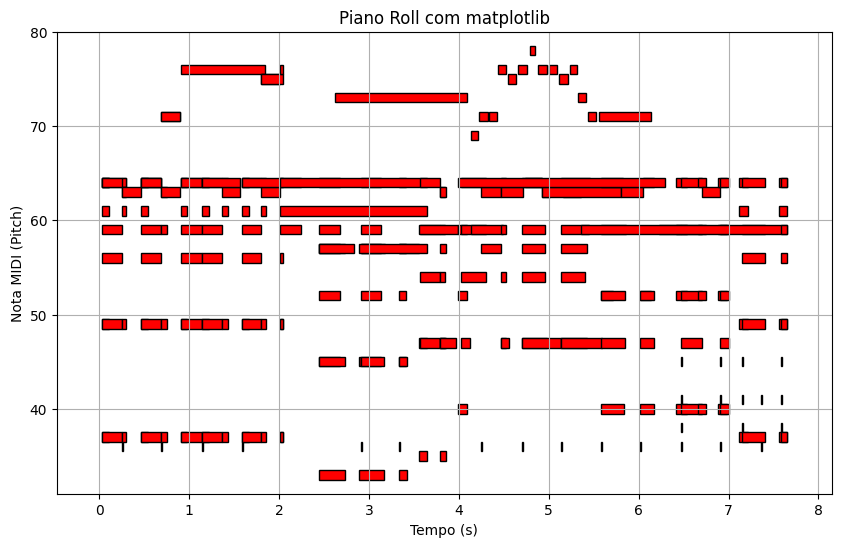

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Função para plotar o piano roll com matplotlib
def plot_piano_roll_matplotlib(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    for idx, row in df.iterrows():
        # Cria um retângulo para cada nota
        rect = patches.Rectangle(
            (row['start_time'], row['pitch'] - 0.5),  # (x, y) posição inicial
            row['duration'],  # Largura do retângulo
            1,  # Altura do retângulo
            linewidth=1,
            edgecolor='black',
            facecolor='red',
            alpha=row['fill_alpha']
        )
        ax.add_patch(rect)
    # Adicionar espaço nos eixos
    ax.set_xlim([df['start_time'].min() - 0.5, df['end_time'].max() + 0.5])
    ax.set_ylim([df['pitch'].min() - 2, df['pitch'].max() + 2])
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Nota MIDI (Pitch)')
    ax.set_title('Piano Roll com matplotlib')
    plt.grid(True)
    plt.show()
# Chama a função para plotar o gráfico
plot_piano_roll_matplotlib(df)

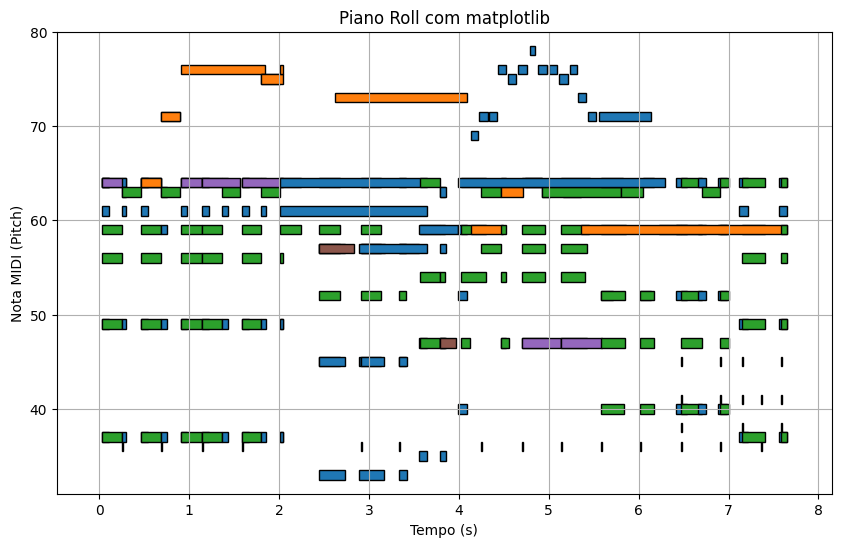

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Função para mapear cada instrumento a uma cor
def get_instrument_color_map(df):
    unique_instruments = df['instrument'].unique()
    colors = list(mcolors.TABLEAU_COLORS)  # Usa cores predefinidas do matplotlib
    color_map = {instrument: colors[i % len(colors)] for i, instrument in enumerate(unique_instruments)}
    return color_map

# Função para plotar o piano roll com matplotlib
def plot_piano_roll_matplotlib(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Obter o mapeamento de cor para os instrumentos
    color_map = get_instrument_color_map(df)

    for idx, row in df.iterrows():
        # Cria um retângulo para cada nota
        rect = patches.Rectangle(
            (row['start_time'], row['pitch'] - 0.5),  # (x, y) posição inicial
            row['duration'],  # Largura do retângulo
            1,  # Altura do retângulo
            linewidth=1,
            edgecolor='black',
            facecolor=color_map[row['instrument']],  # Cor conforme o instrumento
            alpha=row['fill_alpha']
        )
        ax.add_patch(rect)

    # Adicionar espaço nos eixos
    ax.set_xlim([df['start_time'].min() - 0.5, df['end_time'].max() + 0.5])
    ax.set_ylim([df['pitch'].min() - 2, df['pitch'].max() + 2])
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Nota MIDI (Pitch)')
    ax.set_title('Piano Roll com matplotlib')

    # # Criar legenda para os instrumentos
    # legend_patches = [patches.Patch(color=color_map[instrument], label=f'Instrumento {instrument}') 
    #                   for instrument in color_map]
    # ax.legend(handles=legend_patches)

    plt.grid(True)
    plt.show()

# Chama a função para plotar o gráfico
plot_piano_roll_matplotlib(df)


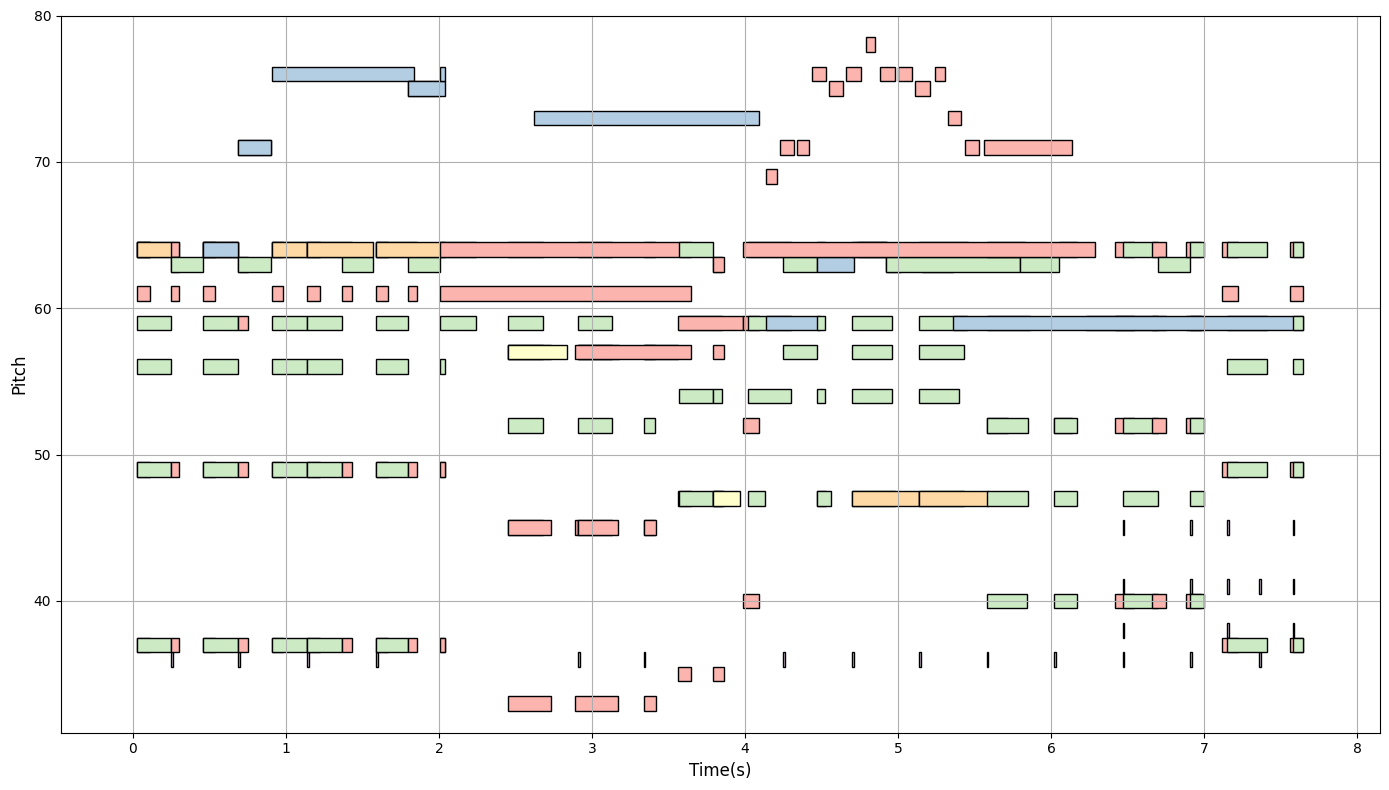

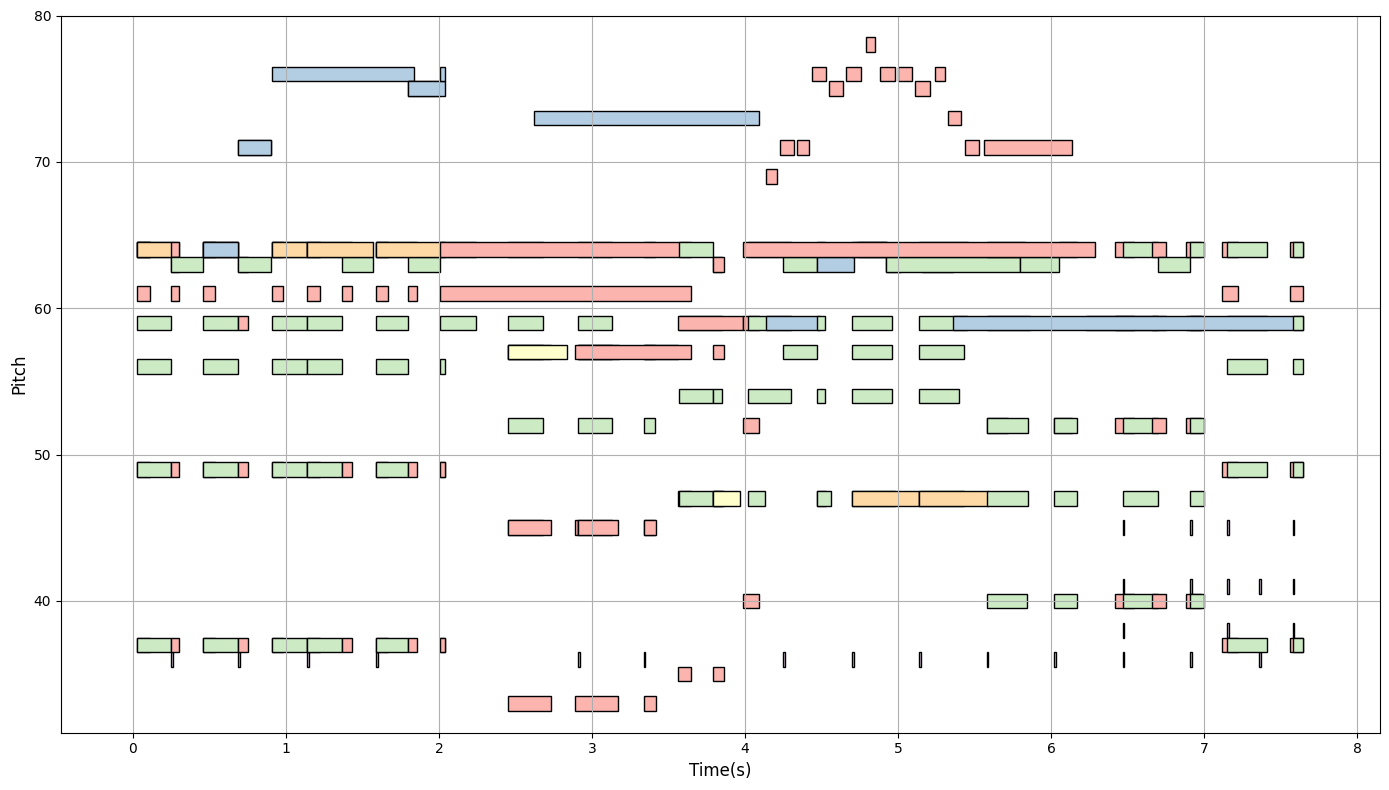

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Function to map each instrument to a pastel color
def get_instrument_color_map(df):
    unique_instruments = df['instrument'].unique()
    pastel_colors = plt.cm.Pastel1.colors  # Use a pastel color palette
    color_map = {instrument: pastel_colors[i % len(pastel_colors)] for i, instrument in enumerate(unique_instruments)}
    return color_map

# Function to plot the piano roll with matplotlib
def plot_notes_seq(df, dpi=300):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Get the color mapping for the instruments
    color_map = get_instrument_color_map(df)

    for idx, row in df.iterrows():
        # Create a rectangle for each note without border
        rect = patches.Rectangle(
            (row['start_time'], row['pitch'] - 0.5),  # (x, y) starting position
            row['duration'],  # Rectangle width
            1,  # Rectangle height
            linewidth=1,
            edgecolor='black',
            facecolor=color_map[row['instrument']],  # Color based on instrument
            alpha=row['fill_alpha']
        )
        ax.add_patch(rect)

    # Adjust axis limits
    ax.set_xlim([df['start_time'].min() - 0.5, df['end_time'].max() + 0.5])
    ax.set_ylim([df['pitch'].min() - 2, df['pitch'].max() + 2])
    ax.set_xlabel('Time(s)', fontsize=12)
    ax.set_ylabel('Pitch', fontsize=12)

    # Export as high-resolution PNG
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return fig

# Call the function to plot and export the high-resolution PNG
plot_notes_seq(df, dpi=300)


In [15]:
# Plot the midi sequence
note_seq.plot_sequence(est_ns)

Loading BokehJS ...

In [16]:
type(note_seq.plot_sequence(est_ns, show_figure=False))

bokeh.plotting._figure.figure

In [17]:
# Downloading the MIDI plot

from selenium import webdriver
from bokeh.io.export import export_png
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

plot = note_seq.plot_sequence(est_ns, show_figure=False)

# Modify the existing figure
plot.toolbar_location = None  # Remove the toolbar
plot.width = 1600  # Increase width for higher quality
plot.height = 900  # Increase height for higher quality

# Adjust the size of axis lines and grid lines
plot.xaxis.axis_line_width = 2  # Width of the x-axis line
plot.yaxis.axis_line_width = 2  # Width of the y-axis line
plot.xaxis.major_tick_line_width = 2  # Width of major ticks on the x-axis
plot.yaxis.major_tick_line_width = 2  # Width of major ticks on the y-axis
plot.xaxis.minor_tick_line_width = 1  # Width of minor ticks on the x-axis
plot.yaxis.minor_tick_line_width = 1  # Width of minor ticks on the y-axis

# Adjust axis labels
plot.xaxis.axis_label = "Time(s)"  # X-axis label text
plot.yaxis.axis_label = "Pitch Notes"  # Y-axis label text
plot.xaxis.axis_label_text_font_size = "14pt"  # Font size of the x-axis label
plot.yaxis.axis_label_text_font_size = "14pt"  # Font size of the y-axis label

# Adjust the size of tick labels
plot.xaxis.major_label_text_font_size = "12pt"  # Font size of major tick labels on the x-axis
plot.yaxis.major_label_text_font_size = "12pt"  # Font size of major tick labels on the y-axis

# Add and adjust title
plot.title.text = "Piano transcription"  # Plot title text
plot.title.text_font_size = "20pt"  # Font size of the title
plot.title.align = "center"  # Align the title to the center

# Configure Chrome driver in headless mode
options = webdriver.ChromeOptions()
options.add_argument('--headless')

# Initialize the Chrome driver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Export the figure as a high-quality PNG
export_png(plot, filename="plot_midi.png", webdriver=driver)

# Close the Chrome driver
driver.quit()



In [18]:
# Downloading the MIDI plot
import json
from selenium import webdriver
from bokeh.io.export import export_png
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bokeh.core.serialization import Serializer
from bokeh.core.json_encoder import serialize_json
from PIL import Image, ImageDraw, ImageFont

plot = note_seq.plot_sequence(est_ns, show_figure=False)

# Modify the existing figure
plot.toolbar_location = None  # Remove the toolbar
plot.width = 1600  # Increase width for higher quality
plot.height = 900  # Increase height for higher quality

# Adjust the size of axis lines and grid lines
plot.xaxis.axis_line_width = 2  # Width of the x-axis line
plot.yaxis.axis_line_width = 2  # Width of the y-axis line
plot.xaxis.major_tick_line_width = 2  # Width of major ticks on the x-axis
plot.yaxis.major_tick_line_width = 2  # Width of major ticks on the y-axis
plot.xaxis.minor_tick_line_width = 1  # Width of minor ticks on the x-axis
plot.yaxis.minor_tick_line_width = 1  # Width of minor ticks on the y-axis

# Adjust axis labels
plot.xaxis.axis_label = "Time(s)"  # X-axis label text
plot.yaxis.axis_label = "Pitch Notes"  # Y-axis label text
plot.xaxis.axis_label_text_font_size = "14pt"  # Font size of the x-axis label
plot.yaxis.axis_label_text_font_size = "14pt"  # Font size of the y-axis label

# Adjust the size of tick labels
plot.xaxis.major_label_text_font_size = "12pt"  # Font size of major tick labels on the x-axis
plot.yaxis.major_label_text_font_size = "12pt"  # Font size of major tick labels on the y-axis

# Add and adjust title
plot.title.text = "Piano transcription"  # Plot title text
plot.title.text_font_size = "20pt"  # Font size of the title
plot.title.align = "center"  # Align the title to the center
s = Serializer()
image_json = s.encode(note_seq.plot_sequence(est_ns, show_figure=False))
print(image_json)

# def json_to_png(json_data, output_file):
#     # Convert JSON to string
#     json_str = json.dumps(json_data, indent=4)
#     # Create an image with white background
#     image = Image.new('RGB', (800, 600), 'white')
#     draw = ImageDraw.Draw(image)
#     # Set the font and size
#     font = ImageFont.load_default()
#     # Draw the JSON text on the image
#     draw.text((10, 10), json_str, font=font, fill='black')
#     # Save the image as PNG
#     image.save(output_file)

# json_to_png(image_json, 'outputs/midi_plot/teste_por_favor.png')






{'type': 'object', 'name': 'Figure', 'id': 'p1561', 'attributes': {'width': 1000, 'height': 400, 'x_range': {'type': 'object', 'name': 'DataRange1d', 'id': 'p1562'}, 'y_range': {'type': 'object', 'name': 'DataRange1d', 'id': 'p1563'}, 'x_scale': {'type': 'object', 'name': 'LinearScale', 'id': 'p1570'}, 'y_scale': {'type': 'object', 'name': 'LinearScale', 'id': 'p1571'}, 'title': {'type': 'object', 'name': 'Title', 'id': 'p1568'}, 'renderers': [{'type': 'object', 'name': 'GlyphRenderer', 'id': 'p1605', 'attributes': {'data_source': {'type': 'object', 'name': 'ColumnDataSource', 'id': 'p1596', 'attributes': {'selected': {'type': 'object', 'name': 'Selection', 'id': 'p1597', 'attributes': {'indices': [], 'line_indices': []}}, 'selection_policy': {'type': 'object', 'name': 'UnionRenderers', 'id': 'p1598'}, 'data': {'type': 'map', 'entries': [('index', {'type': 'ndarray', 'array': {'type': 'bytes', 'data': Buffer(id='p1668', data=<memory at 0x7fb1e529f280>)}, 'shape': [94], 'dtype': 'int32'

## 1.7 Download .mid

In [19]:
# Download the sequences as a midi file 
note_seq.sequence_proto_to_midi_file(est_ns, 'transcribed.mid')